## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

## Create a DataLoader class for training

In [3]:
torch.cuda.current_device()

0

In [4]:
!nvidia-smi

Fri May 20 18:12:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:B1:00.0 Off |                  N/A |
|  0%   32C    P8     9W / 250W |   1436MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [6]:
def train(pred, opt, train_dataset, train_loader, val_dataset, val_loader):
    device = torch.device('cuda:0')
    pred = pred.to(device)
    train_losses = []
    val_losses = []
    
    early_stop_counter = 0
    early_stop_criteria = 25
    dummy = 1
    for epoch in range(120):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            loss = ((preds - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        val_loss = 0
        for i_batch, sample_batch in enumerate(val_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            #print(preds)
            loss = ((preds - out) ** 2).sum()
            val_loss += loss.item()

        train_loss = np.log(total_loss / len(train_dataset))
        val_loss = np.log(val_loss / len(val_dataset))

        if dummy == 1:
            dummy -= 1
        else: 
            last_valid = val_losses[-1]
            if last_valid < val_loss:
                early_stop_counter += 1
            else:
                pickle.dump(pred, open('models/mlp_5_layer_' + city + '_large', 'wb'))

            if early_stop_counter == early_stop_criteria:
                break
            
        print('epoch {} train_loss: {} val_loss: {}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)


    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(val_losses, color ="blue", label = "val_loss")
    plt.legend()
    plt.show()

city: austin
epoch 0 train_loss: 17.87014117569155 val_loss: 12.962345793519233
epoch 1 train_loss: 12.505821329454374 val_loss: 12.408596035158945
epoch 2 train_loss: 12.136461447796087 val_loss: 12.010726434295485
epoch 3 train_loss: 11.850773240104536 val_loss: 11.950728263880295
epoch 4 train_loss: 11.826690027004272 val_loss: 11.97949485738251
epoch 5 train_loss: 11.807978703855616 val_loss: 11.99082451376589
epoch 6 train_loss: 11.796236438403662 val_loss: 11.983523810596083
epoch 7 train_loss: 11.778292542916821 val_loss: 11.966613902467172
epoch 8 train_loss: 11.760561909829386 val_loss: 11.93742368361279
epoch 9 train_loss: 11.730777929907854 val_loss: 11.878274309639671
epoch 10 train_loss: 11.707880677081862 val_loss: 11.830750967032975
epoch 11 train_loss: 11.68691305581352 val_loss: 11.772596022045365
epoch 12 train_loss: 11.65905992786583 val_loss: 11.713305431070559
epoch 13 train_loss: 11.635169699812273 val_loss: 11.646267866325744
epoch 14 train_loss: 11.6060732811722

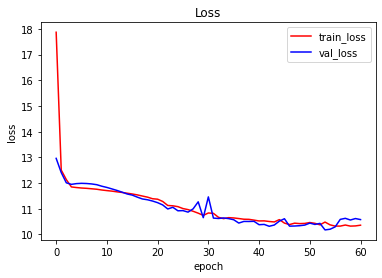

city: miami
epoch 0 train_loss: 19.391137609622614 val_loss: 12.20101264507663
epoch 1 train_loss: 11.972647047869174 val_loss: 11.653437124500845
epoch 2 train_loss: 11.922271112567152 val_loss: 11.520906421059612
epoch 3 train_loss: 11.915780847731671 val_loss: 11.63781159716942
epoch 4 train_loss: 11.9162165889271 val_loss: 11.680572339618545
epoch 5 train_loss: 11.922968509488339 val_loss: 11.556223766430378
epoch 6 train_loss: 11.893018909510815 val_loss: 11.513260703026974
epoch 7 train_loss: 11.885848949833967 val_loss: 11.485725699546839
epoch 8 train_loss: 11.87864066419437 val_loss: 11.52202129795056
epoch 9 train_loss: 11.880149099721246 val_loss: 11.492061731757225
epoch 10 train_loss: 11.898213848951604 val_loss: 11.480717958894255
epoch 11 train_loss: 11.89396030368361 val_loss: 11.491959249844045
epoch 12 train_loss: 11.899815339404517 val_loss: 11.486559343705432
epoch 13 train_loss: 11.871367248676481 val_loss: 11.566528199261677
epoch 14 train_loss: 11.866869981237347

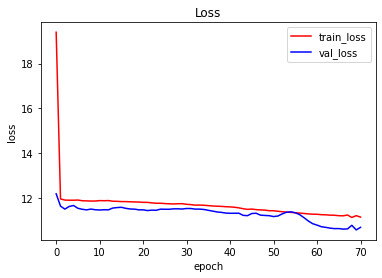

city: pittsburgh
epoch 0 train_loss: 19.151814933118608 val_loss: 17.661214195932573
epoch 1 train_loss: 17.638271573666355 val_loss: 17.660847682716074
epoch 2 train_loss: 17.51441370719359 val_loss: 13.793200736021937
epoch 3 train_loss: 11.97265467430539 val_loss: 11.554415763616268
epoch 4 train_loss: 11.539397241738342 val_loss: 11.533976637255662
epoch 5 train_loss: 11.528311761346659 val_loss: 11.519539080305929
epoch 6 train_loss: 11.527584132314699 val_loss: 11.544778086168293
epoch 7 train_loss: 11.53311172963127 val_loss: 11.725230622142952
epoch 8 train_loss: 11.540196091259068 val_loss: 11.93897694805817
epoch 9 train_loss: 11.550151198579155 val_loss: 12.098394070521442
epoch 10 train_loss: 11.567396026922173 val_loss: 12.199365913417667
epoch 11 train_loss: 11.583107754298137 val_loss: 12.340469042286292
epoch 12 train_loss: 11.597835073875252 val_loss: 12.451309514489255
epoch 13 train_loss: 11.610984644145121 val_loss: 12.483855193742166
epoch 14 train_loss: 11.6143478

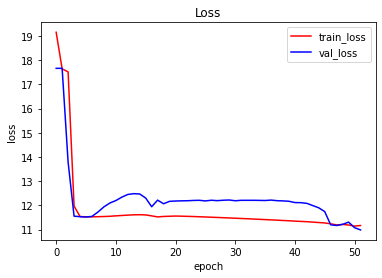

city: dearborn
epoch 0 train_loss: 21.13960001077056 val_loss: 18.176508608038702
epoch 1 train_loss: 16.289089361245754 val_loss: 14.666100930888737
epoch 2 train_loss: 13.91167661836849 val_loss: 12.850575180961293
epoch 3 train_loss: 12.797248883051697 val_loss: 12.554592240314584
epoch 4 train_loss: 12.648269226893625 val_loss: 12.476903438591776
epoch 5 train_loss: 12.627993423891759 val_loss: 12.481762102613068
epoch 6 train_loss: 12.633099752565197 val_loss: 12.469326678795383
epoch 7 train_loss: 12.628469693643538 val_loss: 12.441103872221417
epoch 8 train_loss: 12.620118115587335 val_loss: 12.426614333325597
epoch 9 train_loss: 12.61697983074616 val_loss: 12.439244662237034
epoch 10 train_loss: 12.61712172750083 val_loss: 12.474669468682398
epoch 11 train_loss: 12.611020048328967 val_loss: 12.480528969687274
epoch 12 train_loss: 12.606029780166455 val_loss: 12.505235619094533
epoch 13 train_loss: 12.601452370417888 val_loss: 12.48572911310321
epoch 14 train_loss: 12.5962227904

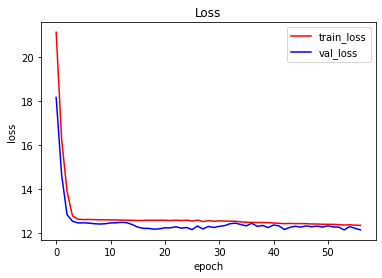

city: washington-dc
epoch 0 train_loss: 19.750893688069088 val_loss: 17.202260717052454
epoch 1 train_loss: 17.197422964136894 val_loss: 17.199682351233395
epoch 2 train_loss: 17.196987791661183 val_loss: 17.19954734182149
epoch 3 train_loss: 17.19692085739921 val_loss: 17.19931087993684
epoch 4 train_loss: 17.196255782765746 val_loss: 17.196849174129685
epoch 5 train_loss: 16.587556910795048 val_loss: 12.98359015872599
epoch 6 train_loss: 12.22200408412322 val_loss: 11.935568580159645
epoch 7 train_loss: 11.856278935090572 val_loss: 11.879573195835496
epoch 8 train_loss: 11.803324534981835 val_loss: 11.85958679868984
epoch 9 train_loss: 11.781405118332023 val_loss: 11.837950281385401
epoch 10 train_loss: 11.771005381314033 val_loss: 11.812701279193313
epoch 11 train_loss: 11.767808649465016 val_loss: 11.773402672457308
epoch 12 train_loss: 11.767477310924754 val_loss: 11.716741986189358
epoch 13 train_loss: 11.771405873966499 val_loss: 11.662138076086336
epoch 14 train_loss: 11.770639

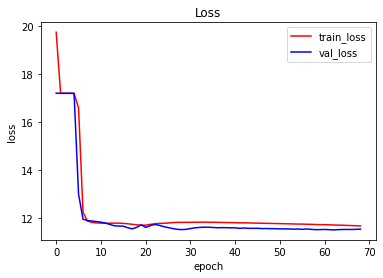

city: palo-alto
epoch 0 train_loss: 19.060442989508513 val_loss: 18.052373527999762
epoch 1 train_loss: 17.790073944029572 val_loss: 16.677285523468257
epoch 2 train_loss: 15.821991257781288 val_loss: 13.662656332376564
epoch 3 train_loss: 12.640434346267558 val_loss: 12.184329785903836
epoch 4 train_loss: 12.26717286935122 val_loss: 12.219935411832141
epoch 5 train_loss: 12.258567877248138 val_loss: 12.183570715970538
epoch 6 train_loss: 12.248960205230656 val_loss: 12.173902994013828
epoch 7 train_loss: 12.235919176725615 val_loss: 12.163627319756404
epoch 8 train_loss: 12.226719507684487 val_loss: 12.153208151175473
epoch 9 train_loss: 12.216669730137424 val_loss: 12.146560084611071
epoch 10 train_loss: 12.207325739895417 val_loss: 12.136276105974797
epoch 11 train_loss: 12.200445186470196 val_loss: 12.12775258105127
epoch 12 train_loss: 12.193456435115078 val_loss: 12.11646938704818
epoch 13 train_loss: 12.187725749780036 val_loss: 12.107970102819422
epoch 14 train_loss: 12.1825085

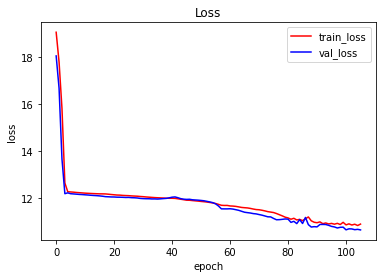

CPU times: user 11min 45s, sys: 11.5 s, total: 11min 56s
Wall time: 11min 56s


In [7]:
%%time
import pickle
#train city models
for city in cities:
    print('city: ' + city)
    batch_sz = 128  # batch size
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_sz)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_sz)
    
    pred = Pred()
    opt = optim.Adam(pred.parameters(), lr=1e-4)
    train(pred, opt, train_dataset, train_loader, val_dataset, val_loader)
#     pickle.dump(pred, open('models/ta_model_baseline_' + city + '_large', 'wb'))

In [8]:
import pandas as pd
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []
for city in cities:
    load_pred = pickle.load(open('models/mlp_5_layer_' + city + '_large', 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda:0')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device))
    preds_reshaped = preds.reshape(preds.size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [9]:
all_predictions

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-33.406445,-563.894165,-33.419022,-565.028748,-35.634411,-564.681641,-33.042194,-564.052612,-34.041065,...,-30.365005,-567.119995,-31.443905,-567.892761,-31.505798,-566.852173,-31.597525,-567.572632,-30.256281,-566.816284
1,1_austin,-347.673401,-18.134064,-347.332275,-17.641876,-347.291290,-18.441837,-347.422119,-17.589626,-348.235352,...,-344.819641,-20.144684,-346.177734,-20.383026,-345.897827,-20.207359,-347.052185,-18.915977,-346.840729,-21.395250
2,2_austin,50.812019,-249.893219,50.324516,-250.046570,50.629704,-249.929398,50.203140,-249.780975,50.496338,...,51.658646,-250.355835,51.673771,-249.891968,51.317451,-250.931427,51.697716,-249.797516,51.780014,-249.884460
3,3_austin,-118.552895,1783.165894,-116.202148,1782.623657,-118.450600,1782.804443,-117.884476,1784.062744,-117.872635,...,-105.606224,1779.746338,-106.163422,1782.395996,-106.086082,1780.949951,-106.000801,1781.232178,-104.338028,1782.074341
4,4_austin,1221.077393,-657.480835,1221.613403,-657.409058,1221.330566,-657.580872,1220.896240,-657.611328,1220.996826,...,1217.778931,-654.946899,1217.480225,-654.846985,1216.928589,-654.891235,1216.828369,-655.126953,1217.774048,-655.284668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1385.336670,-492.127350,-1386.742310,-492.659454,-1381.030396,-497.656555,-1385.916748,-490.535767,-1382.225952,...,-1378.111938,-500.844849,-1380.925415,-500.007629,-1380.296997,-497.489807,-1381.846680,-499.968048,-1380.144531,-496.228760
29839,1682_palo-alto,119.658699,-0.541435,119.983780,-0.605599,119.734894,-0.411325,120.579971,-0.254000,119.997353,...,119.851715,-0.088152,121.118462,-0.496001,120.765984,-0.335056,120.604332,-0.627377,120.830276,-0.321027
29840,1683_palo-alto,-1447.578003,2156.252930,-1447.944458,2157.491211,-1449.660156,2157.250732,-1447.568848,2157.237305,-1448.258911,...,-1450.175293,2156.560791,-1450.546265,2155.609131,-1449.236084,2159.078125,-1448.769897,2156.267822,-1447.610107,2155.730225
29841,1684_palo-alto,1068.259277,1393.699463,1067.181152,1395.233521,1070.958252,1394.618896,1065.263550,1393.995605,1067.704346,...,1070.073975,1395.572998,1066.441406,1394.591797,1069.593384,1395.931152,1066.970947,1393.667969,1070.884644,1396.040405


In [10]:
all_predictions.to_csv('out.csv', index=False)

In [11]:
pd.read_csv('out.csv')

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-33.406445,-563.894170,-33.419020,-565.028750,-35.634410,-564.681640,-33.042194,-564.052600,-34.041065,...,-30.365005,-567.120000,-31.443905,-567.892760,-31.505798,-566.852200,-31.597525,-567.572630,-30.256280,-566.816300
1,1_austin,-347.673400,-18.134064,-347.332280,-17.641876,-347.291300,-18.441837,-347.422120,-17.589626,-348.235350,...,-344.819640,-20.144684,-346.177730,-20.383026,-345.897830,-20.207360,-347.052200,-18.915977,-346.840730,-21.395250
2,2_austin,50.812020,-249.893220,50.324516,-250.046570,50.629704,-249.929400,50.203140,-249.780980,50.496338,...,51.658646,-250.355830,51.673770,-249.891970,51.317450,-250.931430,51.697716,-249.797520,51.780014,-249.884460
3,3_austin,-118.552895,1783.165900,-116.202150,1782.623700,-118.450600,1782.804400,-117.884476,1784.062700,-117.872635,...,-105.606224,1779.746300,-106.163420,1782.396000,-106.086080,1780.950000,-106.000800,1781.232200,-104.338030,1782.074300
4,4_austin,1221.077400,-657.480830,1221.613400,-657.409060,1221.330600,-657.580900,1220.896200,-657.611300,1220.996800,...,1217.778900,-654.946900,1217.480200,-654.847000,1216.928600,-654.891240,1216.828400,-655.126950,1217.774000,-655.284670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1385.336700,-492.127350,-1386.742300,-492.659450,-1381.030400,-497.656560,-1385.916700,-490.535770,-1382.226000,...,-1378.111900,-500.844850,-1380.925400,-500.007630,-1380.297000,-497.489800,-1381.846700,-499.968050,-1380.144500,-496.228760
29839,1682_palo-alto,119.658700,-0.541435,119.983780,-0.605599,119.734890,-0.411324,120.579970,-0.254000,119.997350,...,119.851715,-0.088152,121.118460,-0.496001,120.765980,-0.335056,120.604330,-0.627377,120.830280,-0.321027
29840,1683_palo-alto,-1447.578000,2156.253000,-1447.944500,2157.491200,-1449.660200,2157.250700,-1447.568800,2157.237300,-1448.258900,...,-1450.175300,2156.560800,-1450.546300,2155.609100,-1449.236100,2159.078100,-1448.769900,2156.267800,-1447.610100,2155.730200
29841,1684_palo-alto,1068.259300,1393.699500,1067.181200,1395.233500,1070.958300,1394.618900,1065.263500,1393.995600,1067.704300,...,1070.074000,1395.573000,1066.441400,1394.591800,1069.593400,1395.931200,1066.971000,1393.668000,1070.884600,1396.040400
